# Classification Final University Project :)


## Project Team Members:

- Yazeed Ahmed Kamal // 49-11916
- Omar mohamed khaled // 49-6250
- Joseph Ayman // 49-3854

# Outline

1. Evaluating Model Performance Without Feature Reduction: **(Very Very Overfitting)**
    - [Logistic Regression](#Logistic-Regression)
    - [KNN](#KNN)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Decision Tree](#Decision-Tree)
    - [Naive Bayes](#Naive-Bayes)
    - [Summary Results](#Results-Summary-Over-fitting)

2. Evaluating Model Performance With Feature Reduction:
    - [Logistic Regression](#Logistic-Regression2)
    - [KNN](#KNN2)
    - [Random Forest Classifier](#Random-Forest-Classifier2)
    - [Decision Tree](#Decision-Tree2)
    - [Naive Bayes](#Naive-Bayes2)
    - [Summary Results](#Results-Summary-Good)

- **NOTE**: Some of the results of the classifier will be named logistic regression, even though it belongs to another classifier, such as KNN or decision trees for example, this is just a TYPO, note that the results summaries ARE correctly named

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Evaluating Model Performance Without Feature Reduction

- In this section we will show how different models behave without doing the cross validation or feature reduction we just get the Confusion Matrix, Model Accuracy and ROC Curves for each model

In [2]:
df_ready = pd.read_csv(r'green_trip_data_2019-11_Cleaned.csv')

## Categorize the total amount column into:

- Low: 0 - 10
- Medium: 10 - 30
- High: 30+

**Note that:**: Thes price categories are based the average prices found on the green taxi website and we double checked by visualizing the distribution of the total amount in our dataset

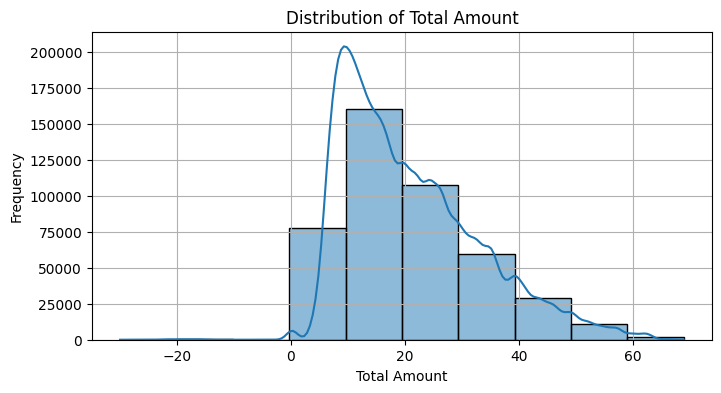

In [3]:
# Plotting the distribution using Seaborn
plt.figure(figsize=(8, 4))
sns.histplot(df_ready['total_amount'], bins=10, kde=True)
plt.title('Distribution of Total Amount')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
# Define the bins and labels
bins = [0, 10, 30, float('inf')]
labels = ['low', 'medium', 'high']
# Create a new column with the discretized values based on the bins
df_ready['price_category'] = pd.cut(df_ready['total_amount'], bins=bins, labels=labels, include_lowest=True, right=False)

In [5]:
# Display rows with NaN values in the 'price_category' column
nan_rows = df_ready[df_ready['price_category'].isna()]
# Drop rows with NaN values in the 'price_category' column
df_ready = df_ready.dropna(subset=['price_category'])

#### Using the label encoder to encode the price category column to use it in the classification

In [6]:
# Create a label encoder instance
label_encoder = LabelEncoder()
# Fit label encoder and transform the 'price_category' column
df_ready['price_category_encoded'] = label_encoder.fit_transform(df_ready['price_category'])

In [7]:
df_ready.head()

,store_and_fwd_flag,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_minutes,"vendor_Creative Mobile Technologies, LLC",vendor_VeriFone Inc.,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,payment_type_Unknown,rate_type_Group ride,rate_type_JFK,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown,pickup_loc_encoded,dropoff_loc_encoded,price_category,price_category_encoded
0,0,1.0,2.80,11.5,0.5,0.5,3.11,0.00,0.3,15.91,11.800000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,64,136,medium,2
1,0,1.0,5.59,20.0,0.5,0.5,3.06,6.12,0.3,30.48,24.900000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,207,124,high,0
2,0,1.0,2.10,10.0,0.5,0.5,2.25,0.00,0.3,13.55,12.016667,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,100,54,medium,2
3,0,1.0,1.23,7.5,0.5,0.5,0.00,0.00,0.3,8.80,8.450000,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,169,233,low,1
4,0,1.0,1.18,7.0,0.5,0.5,0.00,0.00,0.3,8.30,7.466667,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,200,201,low,1


#### Dropping the price category (Categorical) and the total amount which is the main column for finding the price category

In [8]:
df_ready.drop(columns=['price_category','total_amount'], inplace=True)

### Functions to get the model accuracy and plot confusion matrix and ROC curves

This method tunes the best parameters by trying all the different combinations of the different parameters provided to it(meaning it trys all fits) and gives us the best results (best accuracy, best precision, etc...)

In [9]:
def Get_model_results_accuracy(X_train, y_train, X_test, y_test, clf):
     # Fit the model
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Binarize the test labels for ROC curve
    n_classes = len(y_train.unique())
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))

    # ROC curve and AUC for each class
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    else:
        print("Logistic Regression does not support predict_proba method. ROC curve cannot be computed.")
        fpr, tpr, roc_auc = None, None, None

    # Store results in a dictionary
    results = {'Logistic Regression': {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}}

    # Display results
    results_df = pd.DataFrame(results).T
    print(results_df)

    return conf_matrix, n_classes, fpr, tpr, roc_auc

In [10]:
def Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, model):
    # Plot confusion matrix for Logistic Regression
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve for Logistic Regression
    if fpr and tpr and roc_auc:
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC curve data is not available.")

## Normalizing the features
- **Binary data**: Leaving it as it is
- **Continous data**: Normalization using standard Scalar
- **Discrete data**: Scaling using Min-Max Scalar

In [11]:
# Step 2: Separate the binary columns from the continuous columns
binary_data = df_ready.drop(columns=['trip_distance','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','pickup_loc_encoded','dropoff_loc_encoded', 'passenger_count','fare_amount','trip_duration_minutes'])
continuous_data = df_ready[['trip_distance','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','fare_amount','trip_duration_minutes']]
discrete_data = df_ready[['pickup_loc_encoded','dropoff_loc_encoded', 'passenger_count']]

In [12]:
# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Scale the discrete data
scaled_discrete = min_max_scaler.fit_transform(discrete_data)
scaled_discrete_df = pd.DataFrame(scaled_discrete, columns=discrete_data.columns)

# Normalize the continuous data
normalized_continuous = standard_scaler.fit_transform(continuous_data)
normalized_continuous_df = pd.DataFrame(normalized_continuous, columns=continuous_data.columns)

# Combine all the data into one DataFrame
df_ready = pd.concat([binary_data.reset_index(drop=True), normalized_continuous_df, scaled_discrete_df], axis=1)

In [13]:
df_ready

,store_and_fwd_flag,"vendor_Creative Mobile Technologies, LLC",vendor_VeriFone Inc.,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,payment_type_Unknown,rate_type_Group ride,rate_type_JFK,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown,price_category_encoded,trip_distance,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,fare_amount,trip_duration_minutes,pickup_loc_encoded,dropoff_loc_encoded,passenger_count
0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0.024359,-0.711526,0.152529,1.705382,-0.217411,0.449373,-0.330112,-0.308820,0.250980,0.527132,0.0
1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1.101371,-0.711526,0.152529,1.667746,4.729711,0.449373,0.463881,0.809242,0.811765,0.480620,0.0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,2,-0.245859,-0.711526,0.152529,1.058036,-0.217411,0.449373,-0.470228,-0.290328,0.392157,0.209302,0.0
3,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.581702,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.703755,-0.594736,0.662745,0.903101,0.0
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.601003,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.750461,-0.678662,0.784314,0.779070,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447664,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.821038,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.983988,-1.057039,0.447059,0.418605,0.0
447665,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.448987,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.096584,-0.122476,0.392157,0.817829,0.0
447666,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.863501,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.983988,-1.031435,0.278431,0.387597,0.0
447667,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.631885,-0.711526,0.152529,-0.635603,-0.217411,0.449373,-0.843872,-0.873541,0.176471,0.310078,0.0


### Splitting the data into train and test
**Train**: 80%
**Test**: 20%

In [14]:
X = df_ready.drop(columns=['price_category_encoded'])
y = df_ready['price_category_encoded']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic-Regression
- Content for Logistic Regression without feature reduction.

In [16]:
# Initialize the logistic regression model
logistic_regression = LogisticRegression(multi_class='ovr')

                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.995097   0.995125  0.995097  0.995083


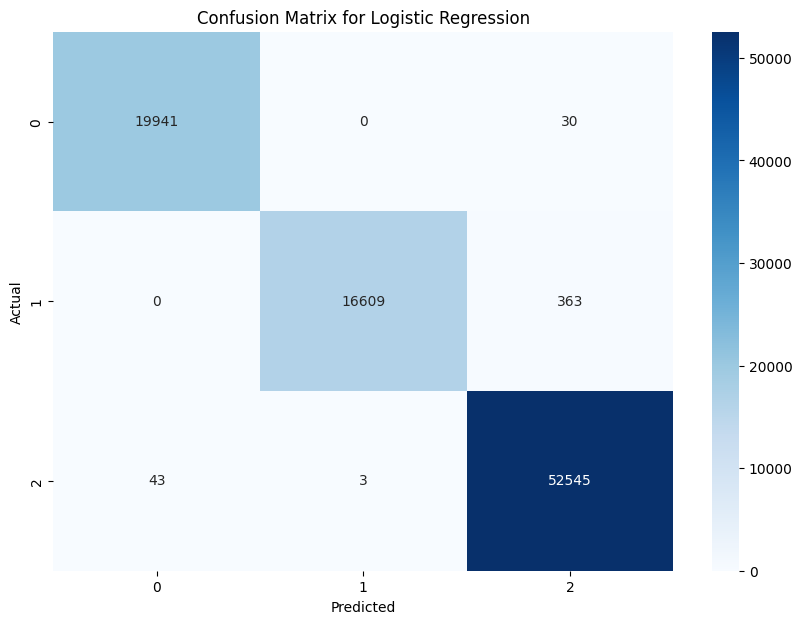

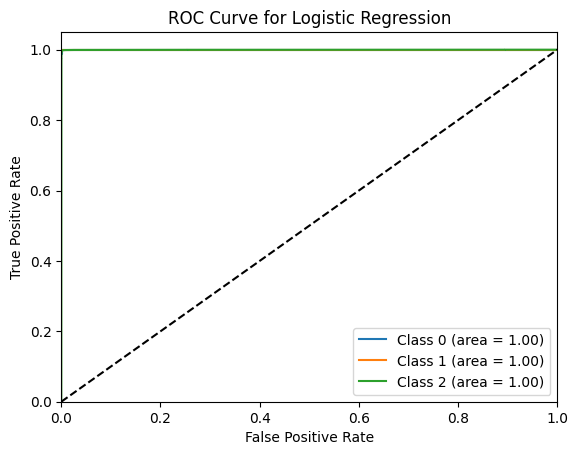

In [17]:
# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, logistic_regression)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Logistic Regression")

# KNN

In [17]:
# Initialize KNN classifier
knn = KNeighborsClassifier()

                     Accuracy  F1-score  Precision    Recall
Logistic Regression  0.988005  0.988002   0.988002  0.988005


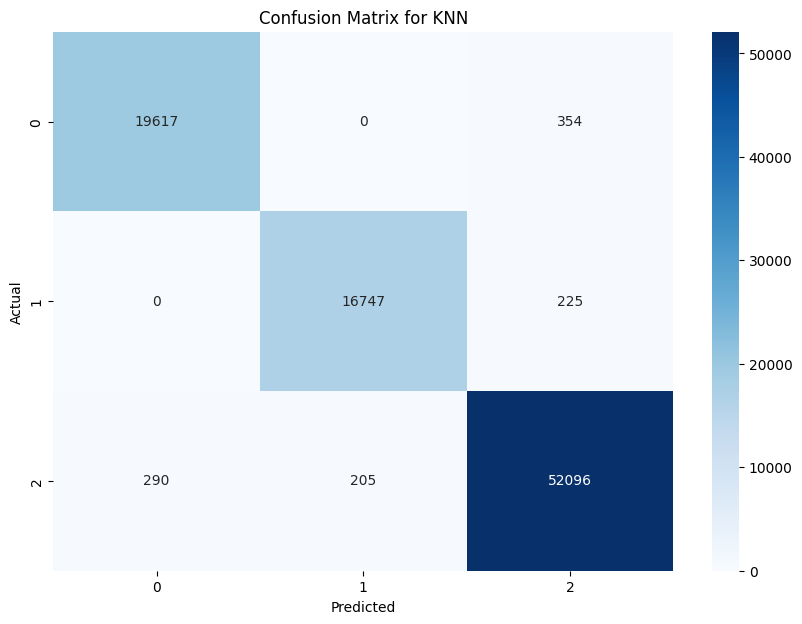

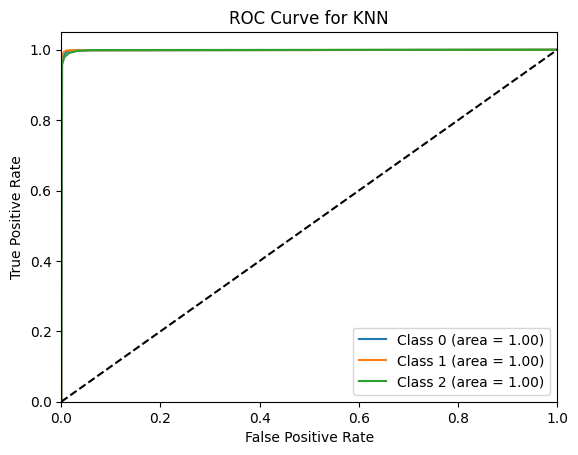

In [18]:
# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, knn)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "KNN")

# Random-Forest-Classifier

In [18]:
# Define the RandomForestClassifier with initial parameters
rf_classifier = RandomForestClassifier(random_state=42)

                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.998559   0.998559  0.998559  0.998559


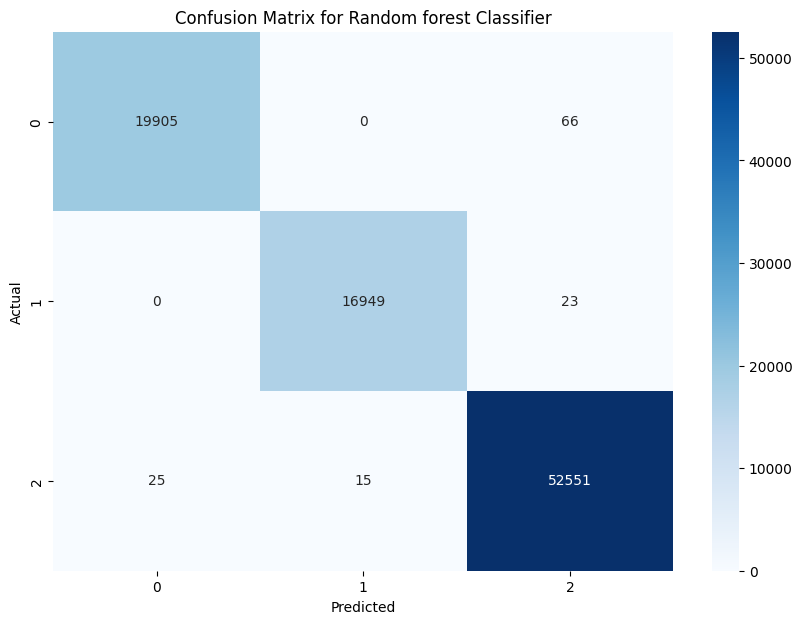

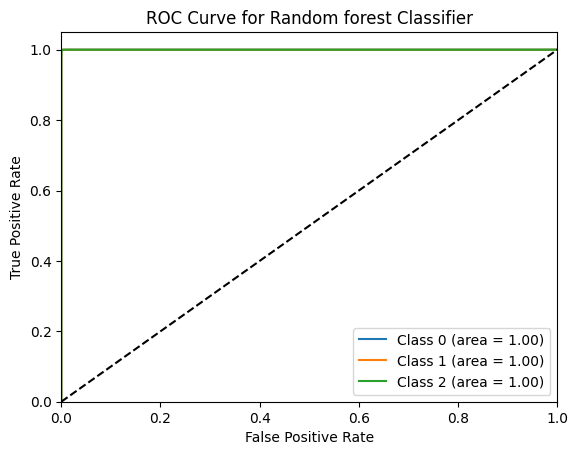

In [19]:
# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, rf_classifier)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Random forest Classifier")

# Decision-Tree

In [20]:
# Define the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.999553   0.999553  0.999553  0.999553


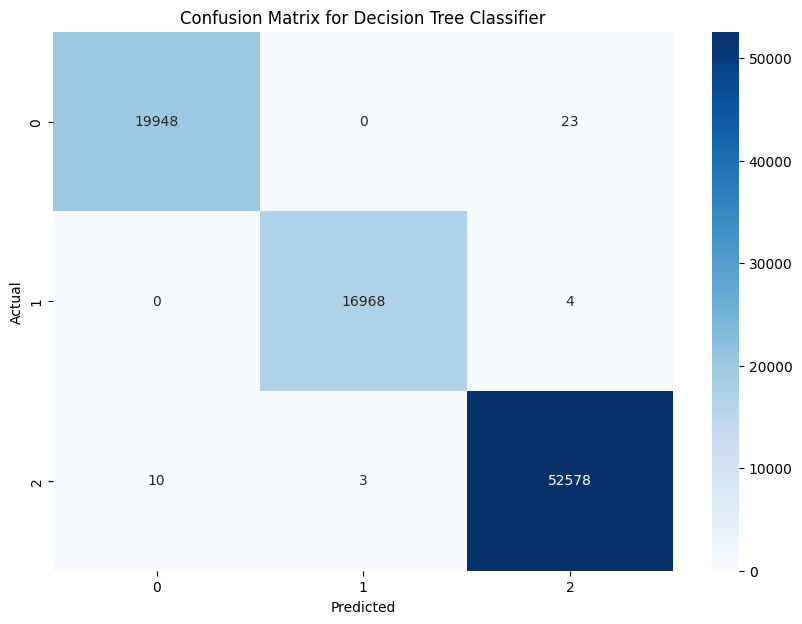

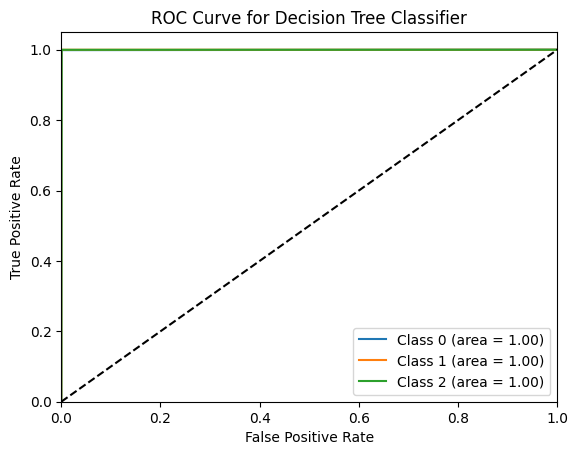

In [21]:
# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, dt_classifier)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Decision Tree Classifier")

# Naive-Bayes

In [22]:
# Define the GaussianNB model
gnb_classifier = GaussianNB()

                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.815612   0.815911  0.815612  0.807412


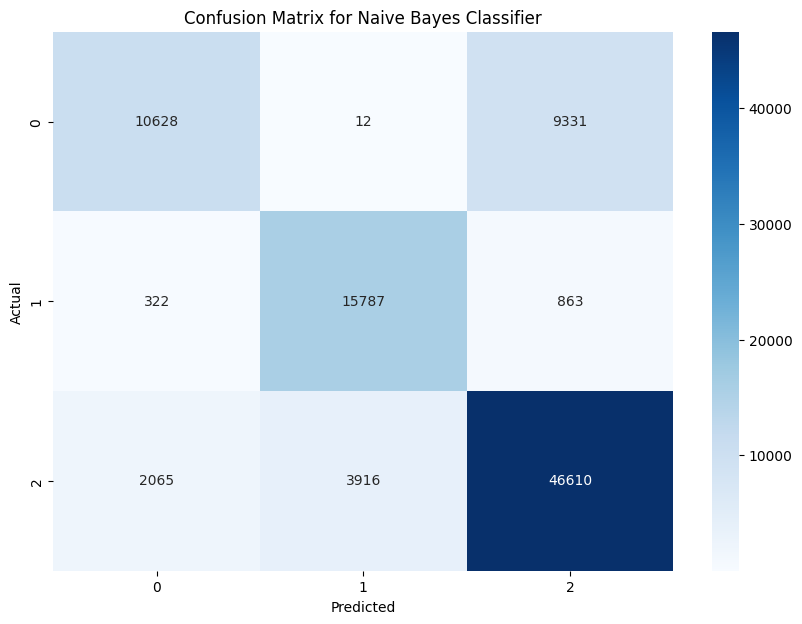

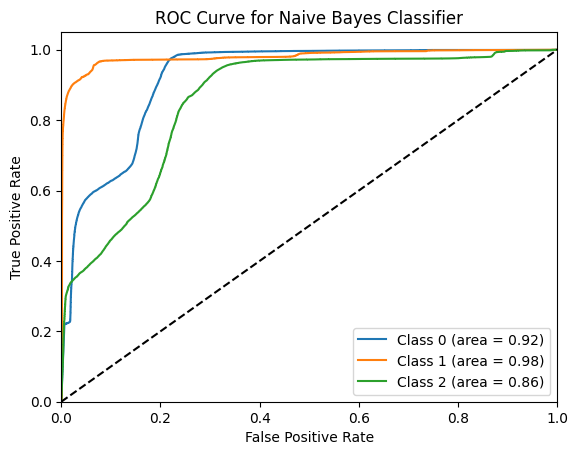

In [23]:
# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, gnb_classifier)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Naive Bayes Classifier")

# Results-Summary-**Over-fitting**

                     Accuracy  Precision    Recall  F1-score
- Logistic Regression:  0.995097 --  0.995125 -- 0.995097 -- 0.995083

           Accuracy  Precision    Recall  F1-score
- KNN:  0.988005 --  0.988002 -- 0.988005 -- 0.988002

                 Accuracy  Precision    Recall  F1-score
- Random Forest:  0.998559 --  0.998559 -- 0.998559 --  0.998559


                 Accuracy  Precision    Recall  F1-score
- Decision Tree:  0.999553 --  0.999553 -- 0.999553 --  0.999553


                 Accuracy  Precision    Recall  F1-score
- Naive Bayes:  0.815612 --  0.815911 -- 0.815612 -- 0.807412

**Best Classifier in overfitting is:** Decision Tree 

# After Feature reduction

After finding that our models overfitted we decided to reduce the features of our data by choosing the features that is having a high correlation with the total amount which is the main effect on the price category

## Using the dataset before encoding to get the correlation matrix (heatmap)

In [ ]:
df_for_corr = pd.read_csv(r'green_trip_data_2019-11_Clean_Not_Encoded.csv')

In [ ]:
df_for_corr.head()

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,trip_duration_minutes
0,VeriFone Inc.,2019-11-01 00:11:24,2019-11-01 00:23:12,N,Standard rate,"Brooklyn,DUMBO/Vinegar Hill","Manhattan,Lower East Side",1.0,2.80,11.5,0.5,0.5,3.11,0.00,0.3,15.91,Credit card,Street-hail,11.800000
1,VeriFone Inc.,2019-11-01 00:49:25,2019-11-01 01:14:19,N,Standard rate,"Queens,Long Island City/Hunters Point","Manhattan,Greenwich Village South",1.0,5.59,20.0,0.5,0.5,3.06,6.12,0.3,30.48,Credit card,Street-hail,24.900000
2,"Creative Mobile Technologies, LLC",2019-11-01 00:57:22,2019-11-01 01:09:23,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Bushwick South",1.0,2.10,10.0,0.5,0.5,2.25,0.00,0.3,13.55,Credit card,Street-hail,12.016667
3,VeriFone Inc.,2019-11-01 00:59:52,2019-11-01 01:08:19,N,Standard rate,"Queens,Astoria","Queens,Sunnyside",1.0,1.23,7.5,0.5,0.5,0.00,0.00,0.3,8.80,Cash,Street-hail,8.450000
4,VeriFone Inc.,2019-11-01 00:40:13,2019-11-01 00:47:41,N,Standard rate,"Queens,Jackson Heights","Queens,Jackson Heights",1.0,1.18,7.0,0.5,0.5,0.00,0.00,0.3,8.30,Cash,Street-hail,7.466667


In [ ]:
numerical_df = df_for_corr[['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax','tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount','trip_duration_minutes']]

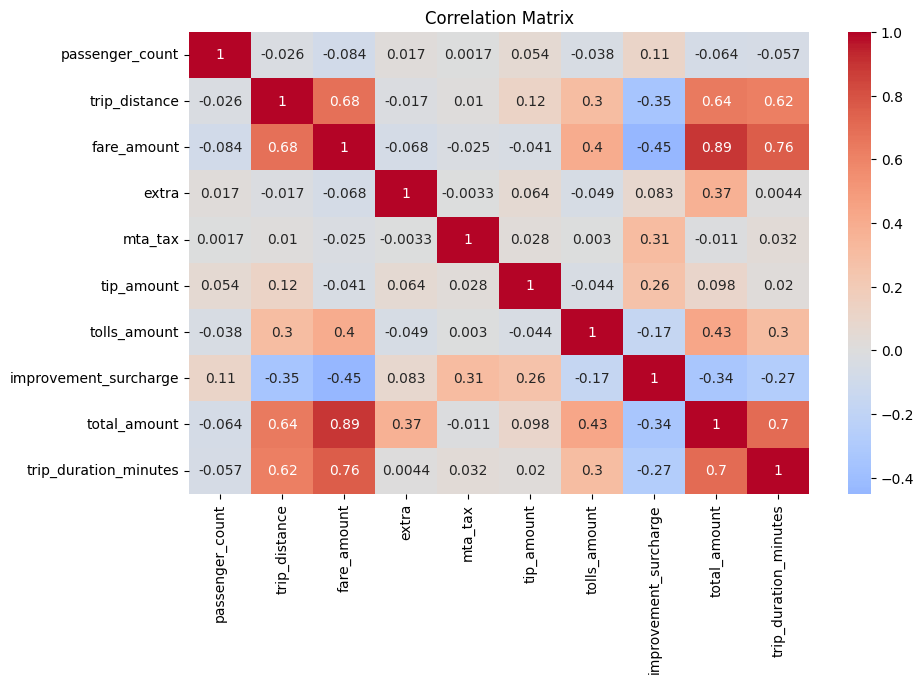

Columns with High correlation with total_amount: ['fare_amount', 'trip_duration_minutes']


In [ ]:
# Compute the correlation matrix
correlation_matrix = numerical_df.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Set a threshold for correlation with total_amount (e.g., 0.7)
threshold = 0.7

# Identify features that are highly correlated with total_amount
correlated_with_total_amount = correlation_matrix['total_amount'].abs() > threshold
correlated_features = correlation_matrix.columns[correlated_with_total_amount].tolist()

# Remove total_amount from the list to avoid dropping it
correlated_features.remove('total_amount')

# Drop the identified columns
numerical_df_dropped = numerical_df.drop(columns=correlated_features)

print(f"Columns with High correlation with total_amount: {correlated_features}")

## Observation:

- Here you can find that the features having high correlation with the total amount is the fare amount and trip duration which makes sense

- **Therefore:** we will drop these column to avoid the overfitting then test the model and find the accuracy to see if our claim that these columns is a reason for overfitting

In [ ]:
df_ready.drop(columns=['fare_amount','trip_duration_minutes'], inplace=True)

In [ ]:
df_ready.head()

,store_and_fwd_flag,passenger_count,trip_distance,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,"vendor_Creative Mobile Technologies, LLC",vendor_VeriFone Inc.,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,payment_type_Unknown,rate_type_Group ride,rate_type_JFK,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown,pickup_loc_encoded,dropoff_loc_encoded,price_category_encoded
0,0,1.0,2.80,0.5,0.5,3.11,0.00,0.3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,64,136,2
1,0,1.0,5.59,0.5,0.5,3.06,6.12,0.3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,207,124,0
2,0,1.0,2.10,0.5,0.5,2.25,0.00,0.3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,100,54,2
3,0,1.0,1.23,0.5,0.5,0.00,0.00,0.3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,169,233,1
4,0,1.0,1.18,0.5,0.5,0.00,0.00,0.3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,200,201,1


In [ ]:
X = df_ready.drop(columns=['price_category_encoded'])
y = df_ready['price_category_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Cross Validation 
This method tunes the best parameters by trying all the different combinations of the different parameters provided to it(meaning it trys all fits) and gives us the best results (best accuracy, best precision, etc...)

In [ ]:
def Get_best_model_parameter(X_train, y_train, model, param_grid):
    # Set up the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print("Best parameters found: ", grid_search.best_params_)

    return grid_search.best_estimator_

In [ ]:
def Get_model_results_accuracy(X_train, y_train, X_test, y_test, best_estimator):
    y_pred = best_estimator.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Binarize the test labels for ROC curve
    n_classes = len(y_train.unique())
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))

    # ROC curve and AUC for each class
    if hasattr(best_estimator, "predict_proba"):
        y_proba = best_estimator.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    else:
        print("Logistic Regression does not support predict_proba method. ROC curve cannot be computed.")
        fpr, tpr, roc_auc = None, None, None

    # Store results in a dictionary
    results = {'Logistic Regression': {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}}

    # Display results
    results_df = pd.DataFrame(results).T
    print(results_df)

    return conf_matrix, n_classes, fpr, tpr, roc_auc

In [ ]:
def Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, model):
    # Plot confusion matrix for Logistic Regression
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve for Logistic Regression
    if fpr and tpr and roc_auc:
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC curve data is not available.")

# Logistic-Regression2

In [ ]:
param_grid = {
    'C': [0.1, 1, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 200]
}

# Initialize the logistic regression model
logistic_regression = LogisticRegression(multi_class='ovr')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
                     Accuracy  Precision    Recall  F1-score
Logistic Regression  0.844461   0.847126  0.844461   0.84084


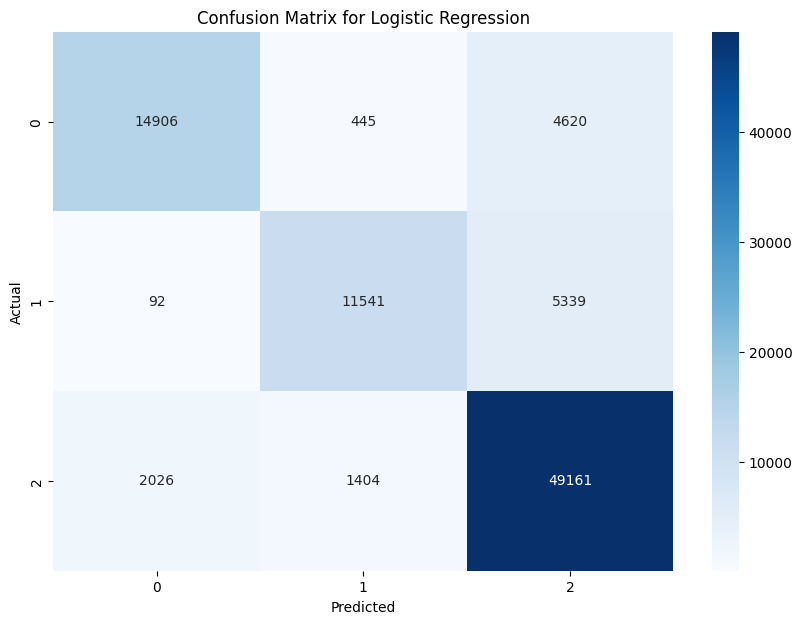

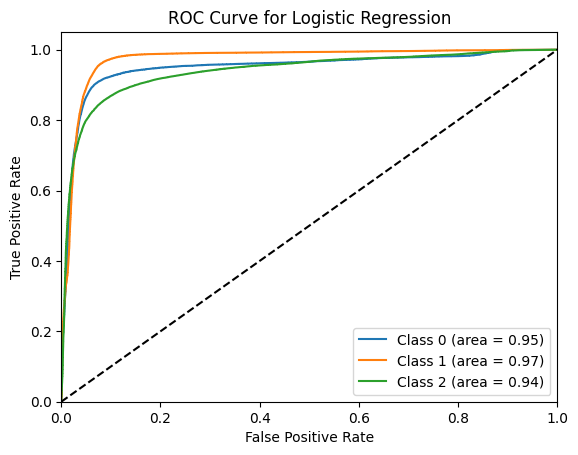

In [ ]:
# Get the best model parameters
best_estimator = Get_best_model_parameter(X_train, y_train, logistic_regression, param_grid)

# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, best_estimator)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Logistic Regression")


# KNN2

     Accuracy  F1-score  Precision    Recall
KNN  0.929289  0.929247    0.92924  0.929289


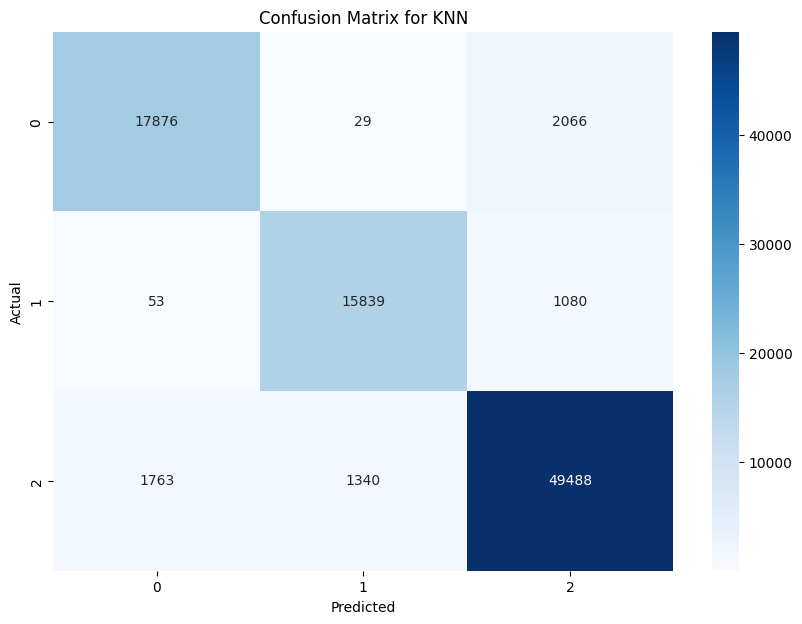

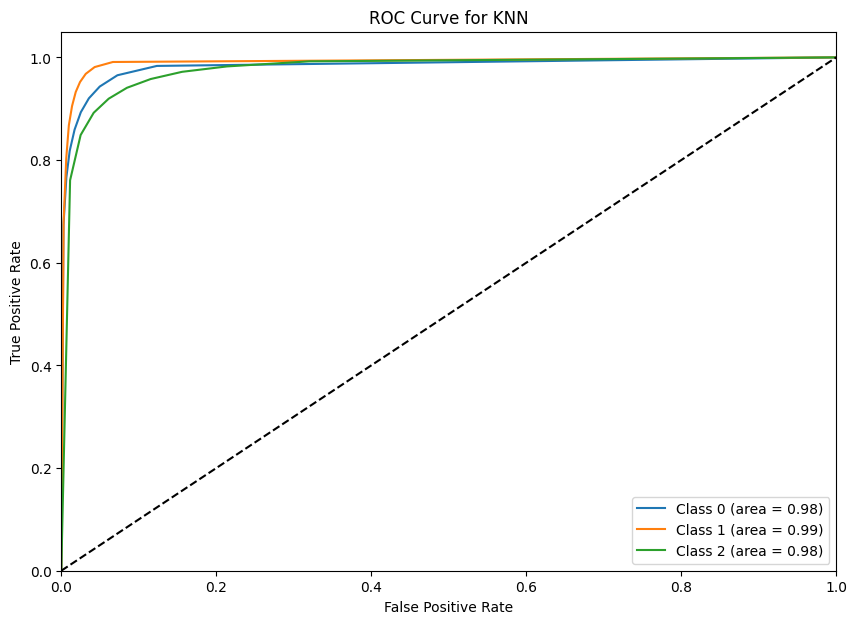

In [ ]:

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    #'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best estimator
best_knn = grid_search.best_estimator_

# Train and evaluate each classifier (including the best KNN)
classifiers = {'KNN': best_knn}

results = {}
conf_matrices = {}
roc_curves = {}
n_classes = len(y_train.unique())
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Adjust the classes if they are different

for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predictions on test set
    y_pred = clf.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices[clf_name] = conf_matrix

    # ROC curve and AUC for each class
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
        roc_curves[clf_name] = (fpr, tpr, roc_auc)
    else:
        print(f"Classifier {clf_name} does not support predict_proba method. ROC curve cannot be computed.")

    # Store results
    results[clf_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrices['KNN'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


if 'KNN' in roc_curves:
    fpr, tpr, roc_auc = roc_curves['KNN']
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for KNN')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Print the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 9}


# Random-Forest-Classifier2

In [ ]:
# Define a parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [10, 20, None],         # Maximum depth of each tree
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
}
# Define the RandomForestClassifier with initial parameters
rf_classifier = RandomForestClassifier(random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}
                     Accuracy  F1-score  Precision    Recall
Logistic Regression  0.937342   0.93722    0.93728  0.937342


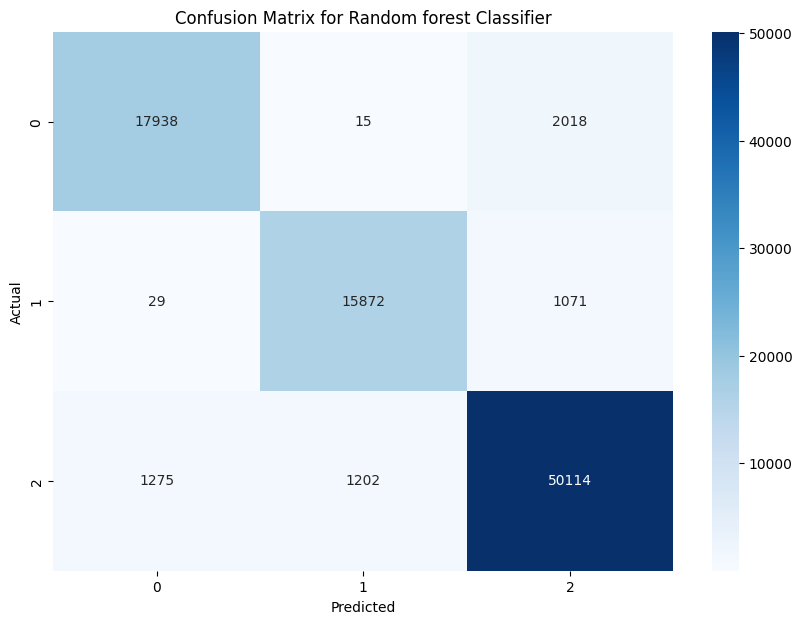

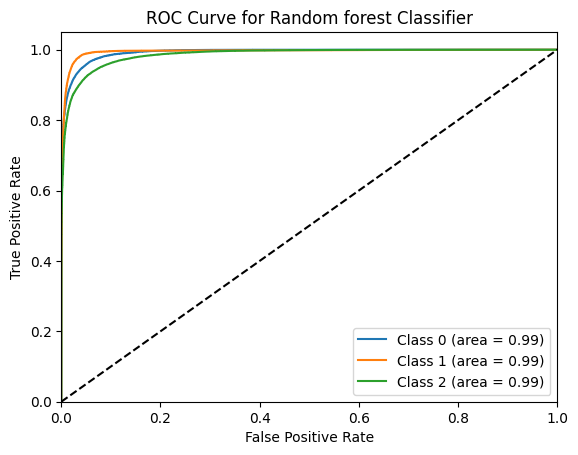

In [ ]:
# Get the best model parameters
best_estimator = Get_best_model_parameter(X_train, y_train, rf_classifier, param_grid)

# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, best_estimator)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Random forest Classifier")

# Decision-Tree2

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterion for splitting (Information Gain vs Gini Impurity)
    'splitter': ['best', 'random'],  # Strategy used to split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree

}
# Define the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}
                     Accuracy  F1-score  Precision    Recall
Logistic Regression  0.929848  0.929757   0.929772  0.929848


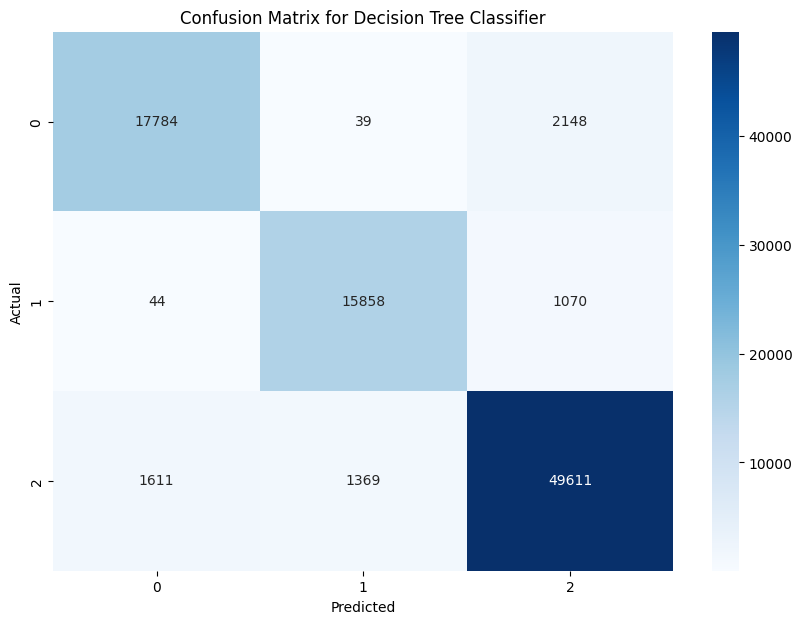

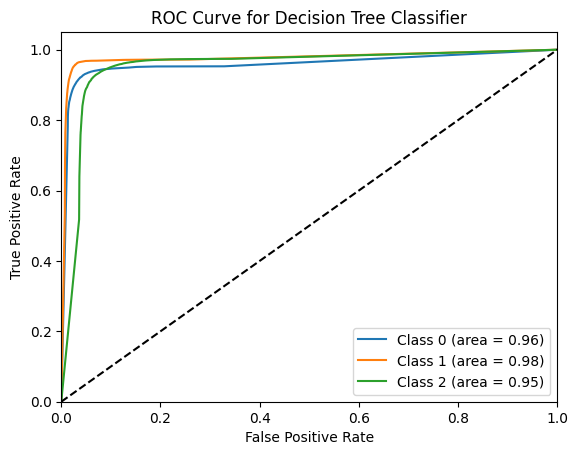

In [ ]:
# Get the best model parameters
best_estimator = Get_best_model_parameter(X_train, y_train, dt_classifier, param_grid)

# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, best_estimator)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Decision Tree Classifier")

# Naive-Bayes2

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Smoothing parameter to avoid zero variance
}
# Define the GaussianNB model
gnb_classifier = GaussianNB()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'var_smoothing': 1e-09}
                     Accuracy  F1-score  Precision    Recall
Logistic Regression  0.742143  0.720422   0.750165  0.742143


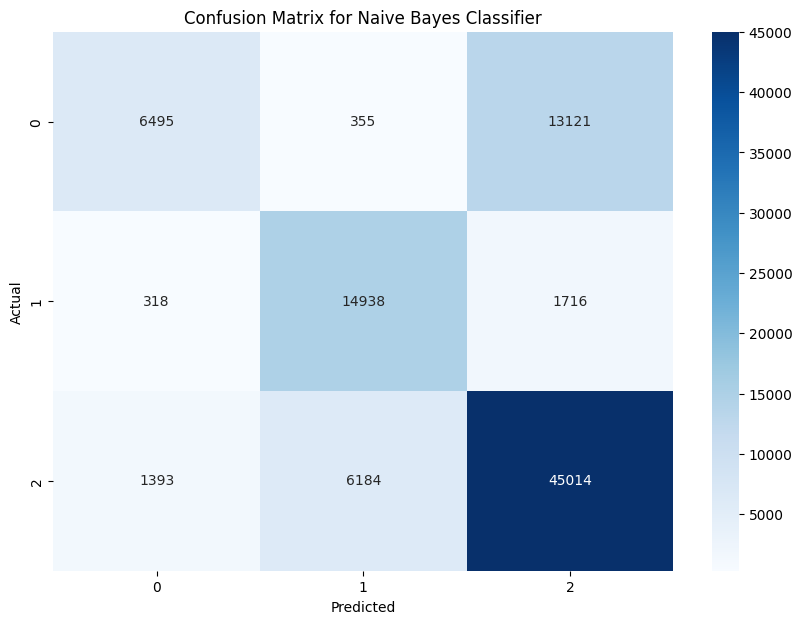

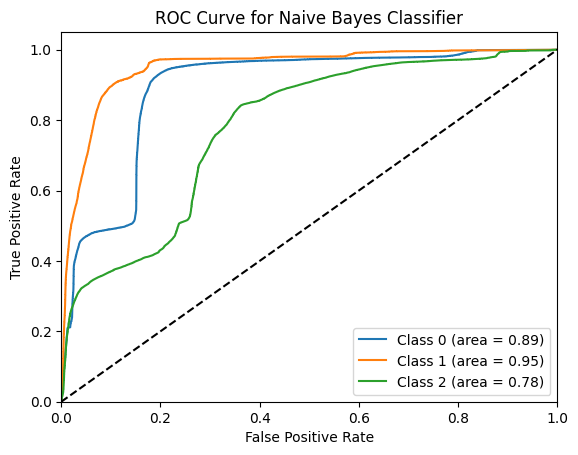

In [ ]:
# Get the best model parameters
best_estimator = Get_best_model_parameter(X_train, y_train, gnb_classifier, param_grid)

# Get model results and accuracy
conf_matrix, n_classes, fpr, tpr, roc_auc = Get_model_results_accuracy(X_train, y_train, X_test, y_test, best_estimator)

# Plot ROC and Confusion Matrix
Plotting_ROC_Confusion(conf_matrix, n_classes, fpr, tpr, roc_auc, "Naive Bayes Classifier")

# Results-Summary-**Good**

                     Accuracy  Precision    Recall  F1-score
- Logistic Regression:  0.844461 --  0.847126 -- 0.844461 -- 0.84084

- Best parameters found:  {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}



                 Accuracy  Precision    Recall  F1-score
- Random Forest:  0.937342 --  0.93728 --  0.937342 --  0.93722

- Best parameters found:  {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}

                 Accuracy  Precision    Recall  F1-score
- Decision Tree:  0.929848 --  0.929772 -- 0.929848 --  0.929757

- Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'}

                 Accuracy  Precision    Recall  F1-score
- Naive Bayes:  0.742143 --  0.750165 -- 0.742143 -- 0.720422

- Best parameters found:  {'var_smoothing': 1e-09}


         Accuracy  Precision    Recall  F1-score
- KNN:  0.929289 --  0.92924 --  0.929289 --  0.929247

- Best parameters found by GridSearchCV: {'metric': 'manhattan','n_neighbors': 9}



**Best Classifier after tuning is:** Random Forest  